In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [40]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=5

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory (
    "PlantVillage",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

it is showing 68 because, every element in the dataset is a bacth of 32 images
32*68=2176
the last bacth is not perfect

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch[0].numpy())

(32, 256, 256, 3)
1


so here image_batch stores all the images label_batch stores all the labels of those images

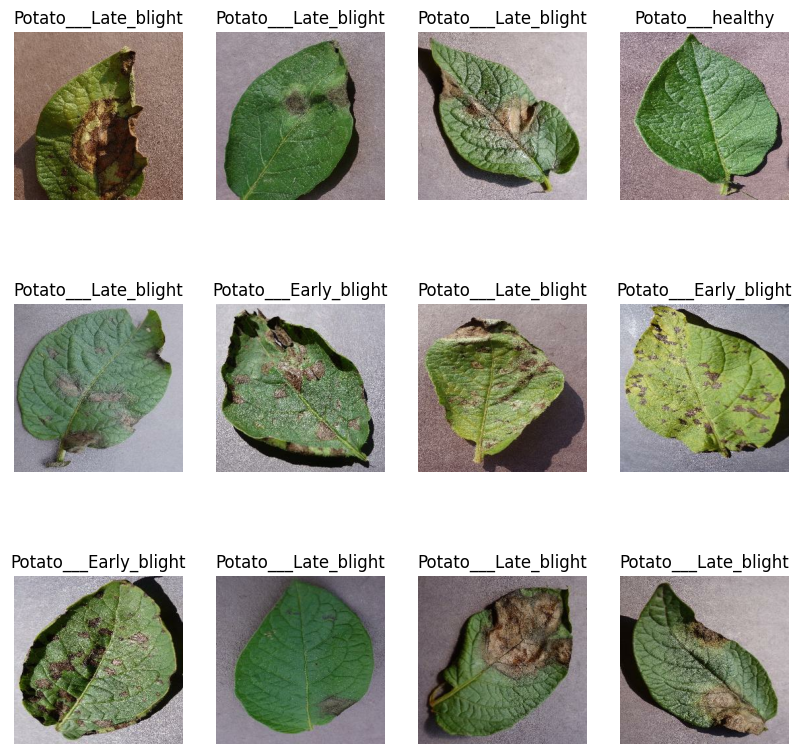

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

This line of code creates a grid of subplots with 3 rows and 4 columns (total of 12 subplots). The third argument i+1 specifies the index of the current subplot within the grid. Since i ranges from 0 to 11 (inclusive), i+1 ranges from 1 to 12, corresponding to the index of each subplot in the grid.

In [9]:
len(dataset)

68

80% = training
20% = 10% validation, 10% test 

In [10]:
train_size =0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_DS= dataset.take(54)
len(train_DS)

54

In [12]:
test_DS= dataset.skip(54)
len(test_DS)

14

arr[54:]: this 54 onwards, arr[:54]: this is first 54

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
Val_DS=dataset.take(6)
len(Val_DS)

6

In [15]:
test_DS=test_DS.skip(6)
len(test_DS)

8

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_DS=ds.take(train_size)
    Val_DS= ds.skip(train_size).take(val_size)
    test_DS= ds.skip(train_size).skip(val_size)
    return train_DS, Val_DS, test_DS

In [17]:
train_DS, Val_DS, test_DS = get_dataset_partitions_tf(dataset)
len(train_DS)

54

In [18]:
train_DS=train_DS.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_DS=Val_DS.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_DS= test_DS.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

it will read the image, next time when you need the image, it will keep the image i memory, improve the performmance of the pipeline

0 TO 255 is the RGB scle, if we divide the by 255 we get a number between 0 and 1

In [19]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

tf.keras.sequential is used in resizing and rescaling

data augmentation is used to make the model Robust 

In [20]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Build model: CNN

In [29]:
input_shape=(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale, data_augmentation, layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

Here (3,3) is filter size
Max pooling size (2,2) is 2 by 2 box, and it pulls the highest pixel in every 2/2 box and create a high pixel 2/2 box at the end 
relu is faster to compute and activation layer for hidden layers is relu
I should learn about neuron and CNN 

did trail and error and figured the layers

softmax function normalizes the probability of the function

In [31]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     multiple                  0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_20 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [36]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy']
)

adam is the best optimiser
we always define neural network first and then compile and optimise, loss function, metrics

In [41]:
history= model.fit(
    train_DS,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=Val_DS
)

Epoch 1/5


54/54 [==============================] - 88s 2s/step - loss: 0.1231 - accuracy: 0.9537 - val_loss: 0.1536 - val_accuracy: 0.9219
Epoch 2/5
54/54 [==============================] - 74s 1s/step - loss: 0.1126 - accuracy: 0.9572 - val_loss: 0.1333 - val_accuracy: 0.9375
Epoch 3/5
54/54 [==============================] - 77s 1s/step - loss: 0.1056 - accuracy: 0.9624 - val_loss: 0.1702 - val_accuracy: 0.9323
Epoch 4/5
54/54 [==============================] - 77s 1s/step - loss: 0.1331 - accuracy: 0.9497 - val_loss: 0.1473 - val_accuracy: 0.9271
Epoch 5/5
54/54 [==============================] - 62s 1s/step - loss: 0.1082 - accuracy: 0.9635 - val_loss: 0.1168 - val_accuracy: 0.9375


In [43]:
scores=model.evaluate(test_DS)

8/8 [==============================] - 2s 194ms/step - loss: 0.0778 - accuracy: 0.9805


In [44]:
history

In [45]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
history.history['accuracy']

[0.9537037014961243,
 0.9571759104728699,
 0.9623842835426331,
 0.9496527910232544,
 0.9635416865348816]

In [50]:
acc=history.history['accuracy']
loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

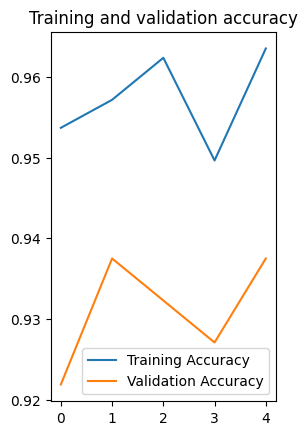

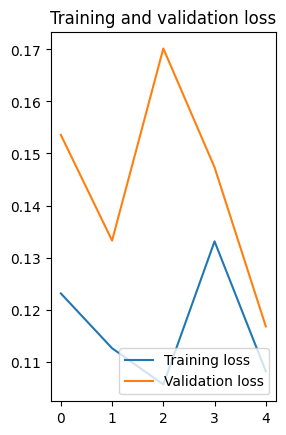

In [60]:
plt.figure(figure=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.figure(figure=(8,8))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and validation loss')

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 272ms/step
[1.2394107e-06 4.8950692e-03 9.9510372e-01]


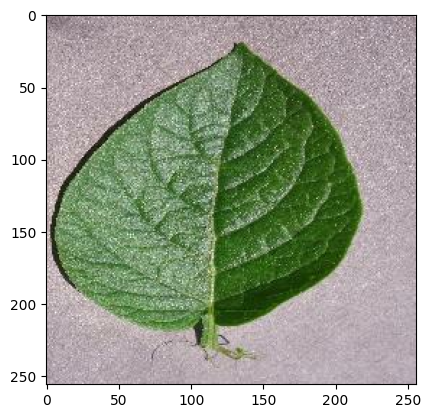

In [68]:
for images_batch, labels_batch in test_DS.take(1):
    first_image= (images_batch[0].numpy().astype('uint8'))
    first_label=labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction= model.predict(images_batch)
    print(batch_prediction[0])